# Classement automatique de textes par réseau de neurones

L’objectif de ce TP est de développer un modèle prédictif pour la classification des thèses scientifiques (données textuelles) à partir d’un apprentissage automatique par réseau de neurones et d'une représentation en sac de mots (bag of words).

## Ensemble de données 
Le tp utilisera un ensemble de données issues des sites de diffusions des thèses soutenues en France : https://tel.archives-ouvertes.fr/ & http://www.theses.fr/.

Dans ce fichier (FICHIER), vous récupérerez des exemples de classements. 
Les titres sont réels, les noms des directeurs ont été modifiés. Des classements ont été posés; certains sont manquants.

Ce répertoire contient donc des titres de thèses classées IA, d'autres non; certains titres n'ont pas de classements.

90% des données classées sont à utiliser en tant que données d'entraînement et 10% seront utilisées en données de test.


---
Si vous utisez colab, vous devrez charger vos fichiers de données dans votre Drive Google.

Pour pouvoir les utiliser, il vous faut monter le répertoir drive pour qu'il soit accessible par colab.
Exécutez le code suivant,  une clé vous sera demandée. Il vous suffit de suivre le lien, de sélectionner votre profile pour obtenir votre clé que vous copierez dans le champs prévu.

In [ ]:
#bloc à exécuter si vous utilisez colab
from google.colab import drive, files

drive.mount('/content/drive')

---
## Préparation des données


### Creations des fichiers de données

A partir du fichier contenant les tables, vous devez créer 2 fichiers texte. 
L'un contenant les titres de thèses classées IA (theseIA.txt) et l'autre les titres de thèses non classées IA (theseNonIA.txt).

Pour débuter, vous pouvez ne considérer qu'une seule feuille (data1) mais plus les fichiers d'exemples seront fournis, meilleur sera l'apprentissage.

**Des titres ne sont pas classés.** Il arrive fréquemment que les données brutes soient incomplètes. Plusieurs solutions existe pour compléter les valeurs manquantes (valeur aléatoire, proportionnellement à la distribution existante, valeur fixe, ...) , ici on ignorera simplement les titres non classés.


### Réduction des exemples
Le nombre de mots utilisés le vocabulaire, étant assez vaste; on le réduit dans un premier temps

### Création du vocabulaire utile

En chargeant l'ensemble des lignes contenues dans les fichers texte, on crée un vocabulaire des mots utiles en :   
  - identifiant les termes (**tokens**) entre espaces,
  - supprimant toute ponctuation,
  - supprimant tous les mots qui ne sont pas uniquement composés de caractères alphabétiques,
  - supprimant tous les mots reconnus en tant que mots vides (stop words) (mots de liaison) français & anglais
  - supprimant tous les mots dont la longueur est <= 2 caractères (sauf IA, AI)

### Chargement et nettoyage des données

Il convient pour chaque fichier texte de créer le  
  - identifier les termes (**tokens**) entre espaces,
  - supprimer toute ponctuation,
  - supprimer tous les mots qui ne sont pas uniquement composés de caractères alphabétiques,
  - supprimer tous les mots reconnus en tant que mots vides (stop words) (mots de liaison) français & anglais
  - supprimer tous les mots dont la longueur est <= 2 caractères (sauf IA, AI)



### Les bibliothèques
La préparation des données implique de pouvoir accéder au système de fichier, ainsi qu'à la bibliothèque nltk et aux bibliothèques spécialisées dans le traitement de texte.. : 

In [2]:
##import pour les fichiers et le traitement de données : 
from os import listdir
import nltk
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
##import pour les réseaux de neurones : 
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import preprocessing
from numpy import array, zeros


In [ ]:
rep = '/Users/.../.../' ## ICI VOTRE REPERTOIRE DE TRAVAIL
# le code suivant charge l'ensemble des mots non importants 
nltk.download("stopwords")


### Fonctions de lectures et d'"épurage" de fichier texte

In [4]:
def load_doc(filename:str)->list:
    """retourne les lignes de texte du fichier filename"""
    # open the file as read only
    with open(filename) as file:
        text = file.read().splitlines() 
    return text

 
def clean_doc(doc)->list:

    """retourne la liste de mots clés inclus dans le texte doc 
    qui ne font pas parti des stop_words"""
    # split into tokens by white space
    tokens = doc.lower()
    tokens = tokens.split()
    # remove punctuation from each token
    # replace '
    tokens = [w.replace('\'', ' ') for w in tokens]
    # replace , ; . etc
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('french'))
    ##Ajouts de mots si vous le desirez
    stop_words.add('vers')
    stop_words.add('lors')
    tokens = [w for w in tokens if not w in stop_words]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if (len(word) > 2 or word=='ia' or word=='ai')]
    # remove final 's' (pural form)
    for i in range(len(tokens)):
        if tokens[i].endswith('s'): tokens[i] = tokens[i][0:len(tokens[i])-1]
    return tokens
 

### Tests de la récupération de mots clés d'un fichier

In [ ]:
def test_recup():
    # mots clés du fichier des theses IA
    filename = rep + '/thesesIA.txt'
    lines = load_doc(filename)
    text = ' '.join(lines)
    tokens = clean_doc(text)
    print('les 10 premiers mots cles de ', filename)
    print(tokens[:10])
    # mots clés du fichier des theses NON IA
    filename = rep + '/thesesNonIA.txt'
    lines = load_doc(filename)
    text = ' '.join(lines)
    tokens = clean_doc(text)
    print('les 10 premiers mots cles de ', filename)
    print(tokens[:10])

In [ ]:
test_recup()

### Construire le vocabulaire global

In [ ]:
def add_doc_to_vocab(filename, vocab):
    """cumule dans la liste vocab les mots du fichier filename 
    (1 seule occurence par mot dans vocab)"""
    # load doc
    lines = load_doc(filename)
    doc = ' '.join(lines)
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

def create_global_vocabulary():
    """creer un vocabulaire (liste de mots clés associés à leurs occurences)
    par la suite, un mot d'un texte ne faisant pas partie du vocabulaire ne sera
    pas compte"""
    vocab = Counter()
    # ajouter les mots cles des repertoire pos et neg
    add_doc_to_vocab(rep+'/thesesIA.txt', vocab)
    add_doc_to_vocab(rep+'/thesesNonIA.txt', vocab)

    # afficher le nb de mots cles trouves
    print("nb de mots cles trouves dans les repertoires : ", len(vocab))
    print("les 10 premiers mots cles du vocabulaire \
    (et leur nb d\'apparition dans les exemples)  : \n", end='')
    i=0
    for (mot,count) in vocab.items(): 
        print(mot,':',count,end=", ")
        i = i+1
        if i>10:break
    # afficher les 10 mots cles les plus utilises
    print("\nles 10 mots cles les plus utilises : ", vocab.most_common(10))

    # ne garder que les mots clés apparaissant au moins 2 fois
    min_occurrence = 2
    tokens = [token for (token,count) in vocab.items() if count >= min_occurrence]
    print('en otant les mots utilise moins de ', min_occurrence, ' fois,', 
          ' nb de mots cles = ',len(tokens))
    return tokens

In [ ]:
## Sauvegarde du vocabulaire
def save_list(lines, filename):
    """sauve les mots de la liste lines dans le fichier filename"""
    # open file
    file = open(filename, 'w')
    data = '\n'.join(lines)
    # write text
    file.writelines(data)
    # close file
    file.close()

In [ ]:
## A la 1ere utilisation, et a chaque modification des fichiers de données
tokens = create_global_vocabulary()
save_list(tokens, 'vocabThesesIA.txt')

### Réduction des entrées
Chaque entrée texte peut être maintenant simplifiée. 
Pour chaque entrée, on extrait les tokens qui ne sont pas présents dans le vocabulaire utile.

In [ ]:
def filter_line(line, vocab)->list:
    """retourne la liste des mots cles de la ligne appartenant au vocabulaire vocab"""
    # clean line
    tokens = clean_doc(line)    
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    return ' '.join(tokens)

Pour chaque fichier d'exemples, on en retire deux listes de lignes épurées, une liste contenant 90% des exemples, et une autre 10%

In [ ]:
def process_train_file(filename, vocab)->list:
    """retourne deux listes des mots cles du repertoire directory; 
    la 1ere liste represente les 90% premieres lignes du fichier, 
    la 2nde represente les 10% restant"""
    lines_firts = list()
    lines_lasts = list()
    i=1
    lines = list()
    # load and clean the file
    with open(filename) as file:
        lines = file.read().splitlines()
    lines_filtered = [filter_line(line, vocab) for line in lines]
    nb_train = int(len(lines_filtered) * 0.9)
    lines_firts.extend(lines_filtered[:nb_train])
    lines_lasts.extend(lines_filtered[nb_train:])
    return (lines_firts,lines_lasts)


In [ ]:
# SI le vocabulaire n'a ete cree dans cette session mais avant ALORS le charger
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab)
# load training and testing examples
(positive_lines_train, positive_lines_test) = process_train_file(rep+'/thesesIA.txt', vocab)
(negative_lines_train, negative_lines_test) = process_train_file(rep+'/thesesNonIA.txt', vocab)
# summarize what we have
print("nb exemples d'entrainement positifs : ", len(positive_lines_train))
print("nb exemples d'entrainement negatifs : ", len(negative_lines_train))
print("nb exemples de tests positifs : ", len(positive_lines_test))
print("nb exemples de tests negatifs : ", len(negative_lines_test))

---
## Représentation en sac de mots



### Convertir les exemples en vecteurs
Chaque exemple doit être transformé dans un vecteur de même format.
On recrée un vocabulaire des mots présents dans les exemples; puis pour chaque exemple, on crée un vecteur de 0, 1 (1 si le ie mot du vocabulaire existe dans l'exemple).

Ainsi tous les exemples de ligne sont transformés en vecteurs de même dimension.

On utilise pour cela un "Tokenizer"


In [ ]:
# create the tokenizer
tokenizer = keras.preprocessing.text.Tokenizer()
# build the training doc based on training data
training_doc = list()
training_doc.extend(positive_lines_train)
training_doc.extend(negative_lines_train)
# ask to the tokenizer to build the bag of words : a set of (word, frequence of use)*
tokenizer.fit_on_texts(training_doc)

"Il ne reste plus qu'à" demander au 'Tokenizer' de réaliser la transformation des exemples d'entrainement en vecteurs d'entrainement.

In [ ]:
xTrain = tokenizer.texts_to_matrix(training_doc, mode='binary')

print('Xtrain contient ', xTrain.shape[0], ' exemples de ', xTrain.shape[1], ' valeurs')
print('une valeur = fréquence d\'apparition des mots dans le vocabulaire global.')
print('Ainsi, premier exemple d\'entrainement = \n', xTrain[0])

#### Création des sorties
Les premiers vecteurs représente des exemples positifs. On crée une sortie constituée d'autant de valeurs [1] suivie de valeurs [0]. 

In [ ]:
#ytrain = suite de (0 (classement pour eval positive),  1 (classements pour éval négative))
yTrain = zeros(len(positive_lines_train)+len(negative_lines_train))
yTrain[:len(positive_lines_train)] = 1

#### Exemples de test
On ré-itère pour les exemples de test; en réutilisant le même 'Tokenizer'

In [9]:
# build the test doc by alternating positive lines and negative lines
test_Doc = list()
test_Doc.extend(positive_lines_test)
test_Doc.extend(negative_lines_test)
# ask to the tokenizer to give the bag of words : a set of (word, frequence of use),
# the words are already kown by the tokenizer*
xTest = tokenizer.texts_to_matrix(test_Doc, mode='binary')
print('Xtest contient ', xTest.shape[0], ' exemples de ', xTest.shape[1], ' valeurs de fréquence.')

#sortie attendues des exemples de test, ytest = suite de (0, 1)
yTest = zeros(len(positive_lines_test)+len(negative_lines_test))
yTest[:len(positive_lines_test)] = 1

---
## Modèle de réseau pour l'analyse des sentiments
Le réseau contient en couche d'entrée aurant de neurones que de tokens retenus. 
Chaque exemple est codé sous forme d'une suite de 0 ou 1, d'une dimension égale au vocabulaire retenu.

xTrain est donc une matrice de n exemples x m colonnes. m étant la dimension des vecteurs d'entrée, c-a-d le nombre de mots finalement pris en comptes, et donc le nombre de neurones de la 1er couche du réseau

In [19]:
# nb de neurones en entrée (= nb de tokens retenus)
## shape[0] est la 1ere dimension d'un tableau (ici le nb d'exemples)
## shape[1] est la 1ere dimension d'un tableau (ici le nb de tokens)
n_words = xTrain.shape[1] 

In [20]:
# TODO: définir la structure du réseau
model = Sequential()
## A VOUS !!!!!
...
...
# compile network 
model.compile(### A VOUS .....


In [ ]:
#TODO tester differents nb de tests (epochs)
history = model.fit(xTrain, yTrain, 
                    validation_data=(xTest, yTest),
                    epochs=10, verbose=2)

### Dessiner l'évolution de l'erreur et de la pertinence

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### Tracer l'erreur d'entrainement / l'erreur de validation
- L'erreur d'entrainement et l'erreur de validation doivent suivre des courbes quasi parallèle.
- L'erreur d'entrainement doit être plus faible que l'erreur de validation
    - si les courbes divergent, si la courbe de validation s'éloigne de la courbe d'entrainement, il y a alors un sur-apprentissage (overfitting) trop adapté aux données d'entrainement, sans doute trop poussé (diminuer les epochs?).
    - s'il y a une erreur d'entrainement trop grande, il y a sous-apprentissage

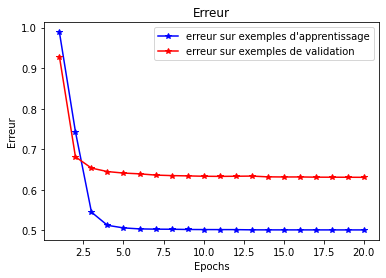

In [22]:
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b-*', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r-*', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

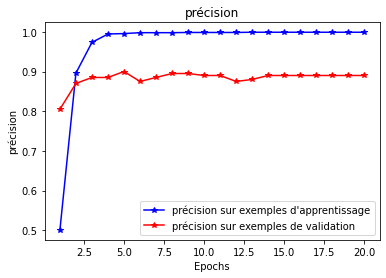

In [23]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b-*', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r-*', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()

### Evaluer le modèle sur l'exemple d'entrainement

In [24]:
# evaluate
loss, acc = model.evaluate(xTest, yTest, verbose=0)
print('Précision sur exemples de test: %f' % (acc*100))

Précision sur exemples de test: 88.999999


---
## Estimation automatique
Bonus. 
Réalisez un code qui permet à partir d'une fichier contenant des titres de thèses de créer un ficher csv indiquant le classement proposé, et la valeur du classement (entre 0 & 1).
Un classement entre 0.4 & 0.6 sera douteux et indiqué par '?'


---
---
## TRAVAIL A RENDRE

* Vous devrez tester différentes architectures de réseau, ainsi que différentes configuration (fonctions d'activation, méthodes de correction d'erreur, méthode de calcul de l'erreur, ...)
* Vous enverrez un fichier contenant pour chaque définition de réseau :
    * l'architecture du réseau (un copier coller du bloc 'TODO: définir la structure du réseau')
    * le déroulé de l'apprentissage (un copier coller du bloc résultat de 'TODO tester differents nb de tests (epochs)'
    * le résultat de 'Test Accuracy'

Au minimum 3 différents réseaux devront être fournis